In [1]:
import shutil
# loading data into python structures
try:
    shutil.rmtree(".data/dnd-cnn-split/train")
    shutil.rmtree("data/dnd-cnn-split/test")
except:
    pass

In [2]:
import os
# ensure directories exist
from pathlib import Path

Path("data/dnd-cnn-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/train/no-damage").mkdir(parents=True, exist_ok=True)

Path("data/dnd-cnn-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/test/no-damage").mkdir(parents=True, exist_ok=True)


In [3]:
all_damage_file_paths = os.listdir('dataset/Project3/damage')
all_no_damage_file_paths = os.listdir('dataset/Project3/no_damage')

In [4]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))


train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train no damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test no damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))


train damage image count:  11336
test damage image count:  2834
len of overlap:  0
train no damage image count:  5721
test no damage image count:  1431
len of overlap:  0


In [5]:
# ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/train/damage', p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/test/damage', p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/train/no-damage', p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/test/no-damage', p) )



# check counts:
print("Files in train/damage: ", len(os.listdir("data/dnd-cnn-split/train/damage")))
print("Files in train/no-damage: ", len(os.listdir("data/dnd-cnn-split/train/no-damage")))

print("Files in test/damage: ", len(os.listdir("data/dnd-cnn-split/test/damage")))
print("Files in test/no-damage: ", len(os.listdir("data/dnd-cnn-split/test/no-damage")))

# shape of damage and no damage training/testing files


Files in train/damage:  14170
Files in train/no-damage:  7152
Files in test/damage:  13028
Files in test/no-damage:  6510


In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# path to training data
train_data_dir = 'data/dnd-cnn-split/train'

# controls the size of the "batches" of images streamed when accessing the datasets.
# this is useful to control the memory usage with very large datasets
batch_size = 32

# target image size
img_height = 150
img_width = 150

# note that the subset parameter can take values of "training", "validation", or "both";
# the value dictates which dataset is returned (we want both)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# rescale instance
rescale = Rescaling(scale=1.0/255)

# apply the rescale to the train and validation sets
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))


2025-04-09 21:43:28.913039: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 21:43:28.962337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 21:43:28.962402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 21:43:28.965056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 21:43:28.975064: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 21:43:28.977012: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Using 4264 files for validation.


In [7]:
# path to test data
test_data_dir = 'data/dnd-cnn-split/test/'

# we do not set subset=both here because we do not want the test set split
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
)

# approach 1: manually rescale data --
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 19538 files belonging to 2 classes.


In [8]:
for images, labels in train_ds.take(1):  # Take one batch
    print("Train batch shape:", images.shape)  # Shape: (batch_size, height, width, channels)
    print("Train labels shape:", labels.shape)  # Shape: (batch_size,)


Train batch shape: (32, 150, 150, 3)
Train labels shape: (32,)


In [9]:
for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape)
    print("Test labels shape:", labels.shape)


Test batch shape: (32, 150, 150, 3)
Test labels shape: (32,)


Label for each of the above images: [0 1 1 1 0]


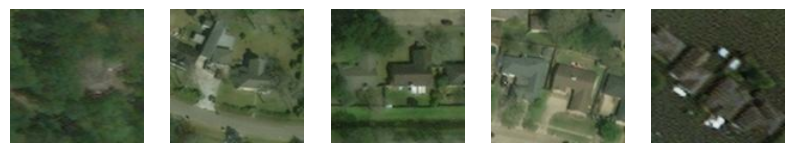

In [10]:
import matplotlib.pyplot as plt

# Get one batch of images and labels from the rescaled dataset
for images, labels in train_rescale_ds.take(1):  
    X_train_batch = images.numpy()  # Convert to NumPy array
    y_train_batch = labels.numpy()  # Convert labels to NumPy
    break

# Plot the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_batch[i])  # No need for uint8 conversion since values are [0,1]
    plt.axis("off")

print('Label for each of the above images:', y_train_batch[:5])


In [11]:
# try different layers and perceptrons to choose the best combination for accuracy

# case 1 (one layer)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(128, activation='relu'),  # Hidden layer with ReLU
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8640257 (32.96 MB)
Trainable params: 8640257 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Train the model
history = model.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=20,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/20
534/534 [==============================] - 32s 59ms/step - loss: 0.8201 - accuracy: 0.6571 - val_loss: 0.5792 - val_accuracy: 0.7019
Epoch 2/20
534/534 [==============================] - 33s 61ms/step - loss: 0.5773 - accuracy: 0.7162 - val_loss: 0.6919 - val_accuracy: 0.6597
Epoch 3/20
534/534 [==============================] - 33s 62ms/step - loss: 0.5596 - accuracy: 0.7298 - val_loss: 0.5637 - val_accuracy: 0.7205
Epoch 4/20
534/534 [==============================] - 33s 62ms/step - loss: 0.5559 - accuracy: 0.7361 - val_loss: 0.6075 - val_accuracy: 0.6604
Epoch 5/20
534/534 [==============================] - 33s 62ms/step - loss: 0.5510 - accuracy: 0.7347 - val_loss: 0.5619 - val_accuracy: 0.7226
Epoch 6/20
534/534 [==============================] - 34s 63ms/step - loss: 0.5504 - accuracy: 0.7331 - val_loss: 0.5639 - val_accuracy: 0.7181
Epoch 7/20
534/534 [==============================] - 33s 62ms/step - loss: 0.5407 - accuracy: 0.7416 - val_loss: 0.5939 - val_accuracy:

In [13]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:}")


611/611 [==============================] - 4s 6ms/step - loss: 0.5498 - accuracy: 0.7237
Test Loss: 0.5498
Test Accuracy: 0.7237


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# case 2 (two layers, adjusted perceptron count)

# Define the model
model2 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(512, activation='relu'),  # Hidden layer with ReLU
    Dense(256, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 67500)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               34560512  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34692097 (132.34 MB)
Trainable params: 34692097 (132.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Train the model
history = model2.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=20,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/20
534/534 [==============================] - 114s 211ms/step - loss: 1.1756 - accuracy: 0.6627 - val_loss: 0.6050 - val_accuracy: 0.6747
Epoch 2/20
534/534 [==============================] - 112s 210ms/step - loss: 0.5991 - accuracy: 0.6971 - val_loss: 0.5985 - val_accuracy: 0.6771
Epoch 3/20
534/534 [==============================] - 112s 210ms/step - loss: 0.5598 - accuracy: 0.7278 - val_loss: 0.5618 - val_accuracy: 0.7106
Epoch 4/20
534/534 [==============================] - 113s 211ms/step - loss: 0.5724 - accuracy: 0.7030 - val_loss: 0.6154 - val_accuracy: 0.6834
Epoch 5/20
534/534 [==============================] - 112s 210ms/step - loss: 0.6007 - accuracy: 0.6623 - val_loss: 0.6118 - val_accuracy: 0.6499
Epoch 6/20
534/534 [==============================] - 112s 210ms/step - loss: 0.5988 - accuracy: 0.6629 - val_loss: 0.5830 - val_accuracy: 0.6499
Epoch 7/20
534/534 [==============================] - 113s 211ms/step - loss: 0.5842 - accuracy: 0.6902 - val_loss: 0.5665 -

In [16]:
# Evaluate on test set
test_loss, test_acc = model2.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:}")


611/611 [==============================] - 9s 14ms/step - loss: 0.5472 - accuracy: 0.7590
Test Loss: 0.5472
Test Accuracy: 0.7590


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# case 3 (3 layers)

# Define the model
model3 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(512, activation='relu'),  # Hidden layer with ReLU
    Dense(256, activation='relu'),   # Another hidden layer
    Dense(128, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model3.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               34560512  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34724865 (132.46 MB)
Trainable params: 34724865 (132.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Train the model
history = model3.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=20, 
    batch_size=32,
    verbose=1
)


Epoch 1/20
534/534 [==============================] - 112s 209ms/step - loss: 0.9689 - accuracy: 0.6568 - val_loss: 0.6406 - val_accuracy: 0.6745
Epoch 2/20
534/534 [==============================] - 112s 210ms/step - loss: 0.5816 - accuracy: 0.7071 - val_loss: 0.8622 - val_accuracy: 0.6510
Epoch 3/20
534/534 [==============================] - 112s 210ms/step - loss: 0.6026 - accuracy: 0.6699 - val_loss: 0.6346 - val_accuracy: 0.6499
Epoch 4/20
534/534 [==============================] - 112s 209ms/step - loss: 0.5937 - accuracy: 0.6630 - val_loss: 0.5851 - val_accuracy: 0.6499
Epoch 5/20
534/534 [==============================] - 111s 208ms/step - loss: 0.5729 - accuracy: 0.7080 - val_loss: 0.7527 - val_accuracy: 0.6503
Epoch 6/20
534/534 [==============================] - 112s 209ms/step - loss: 0.5844 - accuracy: 0.6911 - val_loss: 0.5745 - val_accuracy: 0.7319
Epoch 7/20
534/534 [==============================] - 112s 209ms/step - loss: 0.5772 - accuracy: 0.7111 - val_loss: 0.6163 -

In [19]:
# Evaluate on test set
test_loss, test_acc = model3.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:}")

611/611 [==============================] - 9s 14ms/step - loss: 0.5778 - accuracy: 0.6668
Test Loss: 0.5778
Test Accuracy: 0.6668


In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers  # Following lab's import style
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

#Variant 1: Baseline LeNet-5 with 6 and 16 filters, 120 and 84 neurons.

# Define input shape and number of classes for your dataset
input_shape = (150, 150, 3)  # Your 150x150 RGB images
num_classes = 2  # damage/no-damage
model_lenet5 = models.Sequential()

# Layer 1
model_lenet5.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2
model_lenet5.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Flatten())  

# Layer 3
model_lenet5.add(layers.Dense(120, activation='relu'))

# Layer 4
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer
model_lenet5.add(layers.Dense(num_classes, activation='softmax'))

model_lenet5.compile(optimizer=RMSprop(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
model_lenet5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 73, 73, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 34, 34, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 18496)             0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [21]:
# Fit the model using your preprocessed datasets
history = model_lenet5.fit(
    train_rescale_ds,
    batch_size=32,  # Matches your dataset's batch size
    epochs=20,      # Matches lab's epoch count
    validation_data=val_rescale_ds
)

Epoch 1/20
534/534 [==============================] - 76s 141ms/step - loss: 0.4961 - accuracy: 0.7704 - val_loss: 0.5617 - val_accuracy: 0.7380
Epoch 2/20
534/534 [==============================] - 75s 141ms/step - loss: 0.3621 - accuracy: 0.8574 - val_loss: 0.3312 - val_accuracy: 0.8712
Epoch 3/20
534/534 [==============================] - 76s 143ms/step - loss: 0.3039 - accuracy: 0.8788 - val_loss: 0.3220 - val_accuracy: 0.8687
Epoch 4/20
534/534 [==============================] - 75s 140ms/step - loss: 0.2585 - accuracy: 0.8953 - val_loss: 0.2631 - val_accuracy: 0.8977
Epoch 5/20
534/534 [==============================] - 76s 141ms/step - loss: 0.2200 - accuracy: 0.9125 - val_loss: 0.5069 - val_accuracy: 0.7777
Epoch 6/20
534/534 [==============================] - 74s 139ms/step - loss: 0.1935 - accuracy: 0.9209 - val_loss: 0.3206 - val_accuracy: 0.8633
Epoch 7/20
534/534 [==============================] - 75s 140ms/step - loss: 0.1745 - accuracy: 0.9312 - val_loss: 0.3109 - val_ac

In [22]:
# Evaluate on test set
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.9791
Test loss: 0.0639


In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers  # Following lab's import style
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt


#Variant 2: Increases filters to 12 and 32 for more feature extraction capacity.

# Define LeNet-5 with increased filters
model_lenet5 = models.Sequential()

# Layer 1
model_lenet5.add(layers.Conv2D(12, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2
model_lenet5.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Flatten())  

# Layer 3
model_lenet5.add(layers.Dense(120, activation='relu'))

# Layer 4
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer
model_lenet5.add(layers.Dense(num_classes, activation='softmax'))

# Compile
model_lenet5.compile(optimizer=RMSprop(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summary
model_lenet5.summary()

# Train
history = model_lenet5.fit(
    train_rescale_ds,
    batch_size=32,
    epochs=20,
    validation_data=val_rescale_ds,
    verbose=1
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 12)      912       
                                                                 
 average_pooling2d_2 (Avera  (None, 73, 73, 12)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 32)        9632      
                                                                 
 average_pooling2d_3 (Avera  (None, 34, 34, 32)        0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 36992)             0         
                                                                 
 dense_12 (Dense)            (None, 120)              

In [24]:
# Evaluate
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
print(f"\nVariant 2 - Increased Filters")
print(f"Test accuracy: {test_accuracy:}")
print(f"Test loss: {test_loss:.4f}")


Variant 2 - Increased Filters
Test accuracy: 0.9764
Test loss: 0.0685


In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers  # Following lab's import style
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt


#Variant 3: Keeps original filters but increases dense layers to 256 and 128, adding dropout (0.5) to reduce overfitting.

# Define LeNet-5 with dropout and modified dense layers
model_lenet5 = models.Sequential()

# Layer 1
model_lenet5.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2
model_lenet5.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Flatten())  

# Layer 3
model_lenet5.add(layers.Dense(256, activation='relu'))
model_lenet5.add(layers.Dropout(0.5))  # Added dropout

# Layer 4
model_lenet5.add(layers.Dense(128, activation='relu'))
model_lenet5.add(layers.Dropout(0.5))  # Added dropout

# Output layer
model_lenet5.add(layers.Dense(num_classes, activation='softmax'))

# Compile
model_lenet5.compile(optimizer=RMSprop(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summary
model_lenet5.summary()

# Train
history = model_lenet5.fit(
    train_rescale_ds,
    batch_size=32,
    epochs=20,
    validation_data=val_rescale_ds,
    verbose=1
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 146, 6)       456       
                                                                 
 average_pooling2d_4 (Avera  (None, 73, 73, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 34, 34, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 18496)             0         
                                                                 
 dense_15 (Dense)            (None, 256)              

In [26]:
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
print(f"\nVariant 3 - Dropout and Modified Dense Layers")
print(f"Test accuracy: {test_accuracy:}")
print(f"Test loss: {test_loss:.4f}")


Variant 3 - Dropout and Modified Dense Layers
Test accuracy: 0.9659
Test loss: 0.1096


In [27]:
# adding alternate lenet-5 cnn
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

model_alt_cnn = models.Sequential()

# first block
model_alt_cnn.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# second block 
model_alt_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# third block 
model_alt_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# fourth block 
model_alt_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# flattening
model_alt_cnn.add(layers.Flatten())

# dense layers 
model_alt_cnn.add(layers.Dense(512, activation='relu'))

# output layer
model_alt_cnn.add(layers.Dense(2, activation='softmax'))   # not sure what num to put

model_alt_cnn.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_alt_cnn.fit(train_rescale_ds, batch_size=32, epochs=10)

Epoch 1/10
534/534 [==============================] - 161s 300ms/step - loss: 0.5094 - accuracy: 0.7629
Epoch 2/10
534/534 [==============================] - 160s 300ms/step - loss: 0.3472 - accuracy: 0.8598
Epoch 3/10
534/534 [==============================] - 160s 299ms/step - loss: 0.2438 - accuracy: 0.9036
Epoch 4/10
534/534 [==============================] - 160s 299ms/step - loss: 0.1723 - accuracy: 0.9329
Epoch 5/10
534/534 [==============================] - 159s 298ms/step - loss: 0.1406 - accuracy: 0.9434
Epoch 6/10
534/534 [==============================] - 160s 299ms/step - loss: 0.1191 - accuracy: 0.9546
Epoch 7/10
534/534 [==============================] - 159s 298ms/step - loss: 0.1066 - accuracy: 0.9594
Epoch 8/10
534/534 [==============================] - 159s 298ms/step - loss: 0.0970 - accuracy: 0.9629
Epoch 9/10
534/534 [==============================] - 160s 299ms/step - loss: 0.0910 - accuracy: 0.9629
Epoch 10/10
534/534 [==============================] - 159s 298m

In [28]:
model_alt_cnn.summary()
test_loss, test_accuracy = model_alt_cnn.evaluate(test_rescale_ds, verbose=0)
print("Alternate Lenet-5 CNN accuracy:", test_accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [29]:
# adding alternate lenet-5 cnn
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

model_alt_cnn2 = models.Sequential()

# first block
model_alt_cnn2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# second block 
model_alt_cnn2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# third block 
model_alt_cnn2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# fourth block 
model_alt_cnn2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# flattening
model_alt_cnn2.add(layers.Flatten())

# dense layers 
model_alt_cnn2.add(layers.Dense(512, activation='relu'))

# output layer
model_alt_cnn2.add(layers.Dense(2, activation='softmax'))   # not sure what num to put

model_alt_cnn2.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_alt_cnn2.fit(train_rescale_ds, batch_size=32, epochs=20)

Epoch 1/20
534/534 [==============================] - 160s 298ms/step - loss: 0.5028 - accuracy: 0.7677
Epoch 2/20
534/534 [==============================] - 159s 298ms/step - loss: 0.3495 - accuracy: 0.8573
Epoch 3/20
534/534 [==============================] - 160s 299ms/step - loss: 0.2554 - accuracy: 0.9012
Epoch 4/20
534/534 [==============================] - 160s 299ms/step - loss: 0.1898 - accuracy: 0.9261
Epoch 5/20
534/534 [==============================] - 160s 299ms/step - loss: 0.1523 - accuracy: 0.9413
Epoch 6/20
534/534 [==============================] - 160s 299ms/step - loss: 0.1286 - accuracy: 0.9482
Epoch 7/20
534/534 [==============================] - 160s 299ms/step - loss: 0.1142 - accuracy: 0.9540
Epoch 8/20
534/534 [==============================] - 160s 299ms/step - loss: 0.1019 - accuracy: 0.9603
Epoch 9/20
534/534 [==============================] - 159s 297ms/step - loss: 0.0932 - accuracy: 0.9630
Epoch 10/20
534/534 [==============================] - 158s 297m

In [30]:
model_alt_cnn2.summary()
test_loss, test_accuracy = model_alt_cnn2.evaluate(test_rescale_ds, verbose=0)
print("Alternate Lenet-5 CNN accuracy:", test_accuracy)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [31]:
model_alt_cnn2.save('./models/model_alt_cnn2.keras')